# Investigating Fandango Movie Ratings

In this project, we will investigate Fandango movie ratings. These ratings go from zero to five stars, in increment of 0.5 stars. In this [article](https://fivethirtyeight.com/features/fandango-movies-ratings/), Walt Hickey finds out that the ratings displayed on Fandago's website are higher than the actual ratings. More precisely:

- The rating is almost always rounded up to the next multiple of 0.5. For example, 4.1 would be rounded to 4.5 instead of 4.
- In 8% of the ratings he analyzed, the rouding was to the nearest whole star. For example, 4.5 to 5 stars.
The article was written in 2015. Our goal for this project is to determine if Fandango reacted to this article and changed its rating methodology in 2016.

## 1. Data Cleaning

Importing useful libraries :

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We have two datasets for this project. The first one, fandango_score_comparison.csv, is the original dataset used by Hickey, which contains data for the year 2015. The second contains data from Fandango collected by the Dataquest team in 2016-2017. We will compare the two datasets. First, we open them :

In [2]:
ratings_15 = pd.read_csv('fandango_score_comparison.csv')

ratings_16_17 = pd.read_csv('movie_ratings_16_17.csv')

In [3]:
ratings_15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILM                        146 non-null    object 
 1   RottenTomatoes              146 non-null    int64  
 2   RottenTomatoes_User         146 non-null    int64  
 3   Metacritic                  146 non-null    int64  
 4   Metacritic_User             146 non-null    float64
 5   IMDB                        146 non-null    float64
 6   Fandango_Stars              146 non-null    float64
 7   Fandango_Ratingvalue        146 non-null    float64
 8   RT_norm                     146 non-null    float64
 9   RT_user_norm                146 non-null    float64
 10  Metacritic_norm             146 non-null    float64
 11  Metacritic_user_nom         146 non-null    float64
 12  IMDB_norm                   146 non-null    float64
 13  RT_norm_round               146 non

This dataset contains ratings from many websites. However, we are only interested in Fandango ratings. From the readme file associated to this database, we see that the columns concerning Fandango are :

- 'FILM' contains the title of the movie
- 'Fandango_Stars' contains the number of stars displayed for the movie on Fandango's website
- 'Fandango_Ratingvalue' contains the actual average of the users ratings
- 'Fandango_Difference' is the difference between 'Fandango_Stars' and - 'Fandango_Ratingvalue'. It measures how inflated a rating is.
- 'Fandango_votes' is the number of user ratings the movie had on Fandango

We will only keep these columns.

In [4]:
ratings_15 = ratings_15[['FILM'
                       ,'Fandango_Stars'
                       ,'Fandango_Ratingvalue'
                       ,'Fandango_votes'
                       ,'Fandango_Difference']]

In [5]:
#We can display the first few rows :

ratings_15.head(5)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [6]:
ratings_16_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movie         214 non-null    object 
 1   year          214 non-null    int64  
 2   metascore     214 non-null    int64  
 3   imdb          214 non-null    float64
 4   tmeter        214 non-null    int64  
 5   audience      214 non-null    int64  
 6   fandango      214 non-null    float64
 7   n_metascore   214 non-null    float64
 8   n_imdb        214 non-null    float64
 9   n_tmeter      214 non-null    float64
 10  n_audience    214 non-null    float64
 11  nr_metascore  214 non-null    float64
 12  nr_imdb       214 non-null    float64
 13  nr_tmeter     214 non-null    float64
 14  nr_audience   214 non-null    float64
dtypes: float64(10), int64(4), object(1)
memory usage: 25.2+ KB


For the 16-17 dataset, the only columns we're in interest in are:

'movie', containing the movie's title
'year', containing the year of release
'fandango', containing Fandango's rating for this movie.

In [7]:
ratings_16_17 = ratings_16_17[['movie'
                               ,'year'
                               ,'fandango']]

In [8]:
#Let's display the first few rows :

ratings_16_17.head(5)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


These two samples only contain movie with a significant number of reviews of Fandango. For the 2015 sample, the readme states that this means movie with 30 or more ratings. For the 2016-2017, this means the movies released in 2016-2017 with the most reviews (on the four websites Fandango, Rotten Tomatoes, IMDB, Metacritic).

Therefore, the two datasets are sampled in a similar way. They are not representative, as we are not looking at movies with few ratings. However, it does make sense to only look at movies with a lot of ratings for two reasons :

- By definition, their rating is based on more data.
- These movies will tend to be seen by a lot of people. Thus, an inflated rating on these will have the most influence on customer behavior.

Given the analysis in the previous cell, we can thus change our goal to determining whether Fandango inflates the ratings of movies with many reviews. Restricting our analysis to this smaller set of movies makes our sample more representative. We can check that every movie in the 2015 database has at least 30 reviews :

In [9]:
ratings_15[ratings_15['Fandango_votes']<30]

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference


Unfortunately, no such data is available in the 2016-2017 database. Moreover, the Fandango website has drastically changed since 2017. Their review system is now powered by Rotten Tomatoes, and their is no way to access the number of reviews a movie had in 2016-2017. Thus, we will have to trust the second database.

Before we start the analysis, recall that we are interested in the difference between 2015 and 2016. Thus, we are only interested in movies released in these two years. For the 2016-2017 databases, we can find these using the 'year' column :

In [10]:
after = ratings_16_17[ratings_16_17['year'] == 2016]
after.reset_index(inplace = True, drop = True)

In [11]:
after.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   movie     191 non-null    object 
 1   year      191 non-null    int64  
 2   fandango  191 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.6+ KB


In [12]:
after.head(5)

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Hologram for the King,2016,3.0
4,A Monster Calls,2016,4.0


In [13]:
before = ratings_15[ratings_15['FILM'].str.contains('2015')]
before.reset_index(inplace = True, drop = True)

In [14]:
before.head(5)

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [15]:
before.isnull().sum()

FILM                    0
Fandango_Stars          0
Fandango_Ratingvalue    0
Fandango_votes          0
Fandango_Difference     0
dtype: int64

In [16]:
after.isnull().sum()

movie       0
year        0
fandango    0
dtype: int64

## 2. Kerdel Density Plot of Movie Ratings

We will start our analysis by generating kernel density plots for the years 2015 and 2016. If Fandango corrected their rating algorithm, we should see a shift of the ratings to the left in 2016.

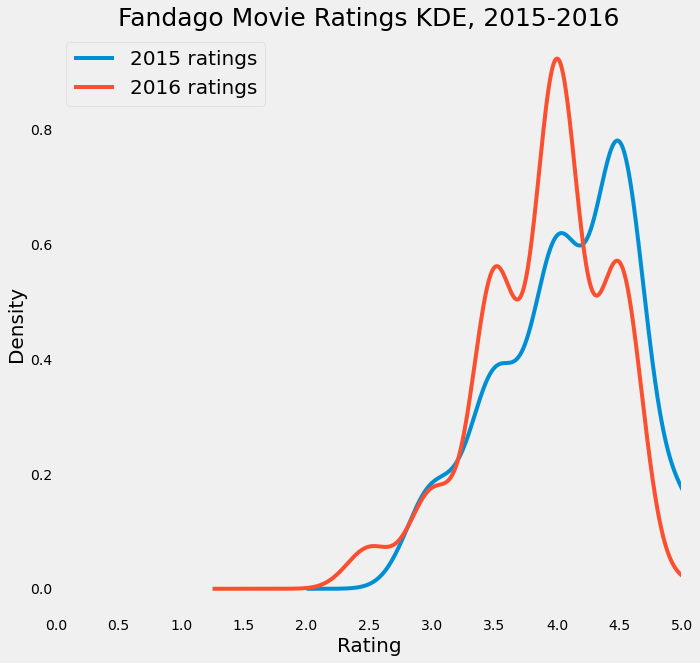

In [17]:
# Use the FTE style
plt.style.use('fivethirtyeight')

#Creating plot and figure

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(1,1,1)

#Setting limits and ticks

ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
ax.set_xlim(0,5)

ax.set_title('Fandago Movie Ratings KDE, 2015-2016', size = 25)

#Plotting the KDEs

before['Fandango_Stars'].plot.kde(label = '2015 ratings')

after['fandango'].plot.kde(label = '2016 ratings')

#Adding legend

ax.legend(loc = 'upper left', fontsize = 20)

#Adding axes labels

ax.set_xlabel('Rating',fontsize = 20)
ax.set_ylabel('Density', fontsize = 20)

# Removing grid
ax.grid(False)

Looking at these curves, we notice:

- There was indeed a shift to the left in 2016
- The distribution of the ratings in 2016 looks less right-skewed than in 2015.

Both of these observations seem to indicate that Fandango did in fact correct their algorithm.

## 3. A deeper analysis

We would like to compare the two distribution more accurately. To do so, can compute the normalized rating distributions for the two years, and substract them.

In [18]:
ratings_dist_15 = before['Fandango_Stars'].value_counts(normalize = True)*100
#Adding zero for the 2.5 rating so we can substract from 2016
ratings_dist_15[2.5] = 0.0
ratings_dist_15.sort_index(inplace = True)

ratings_dist_16 = after['fandango'].value_counts(normalize = True)*100
ratings_dist_16.sort_index(inplace = True)

In [19]:
shift = ratings_dist_16-ratings_dist_15
shift

2.5     3.141361
3.0    -1.197289
3.5     6.254312
4.0    11.631966
4.5   -13.377166
5.0    -6.453184
dtype: float64

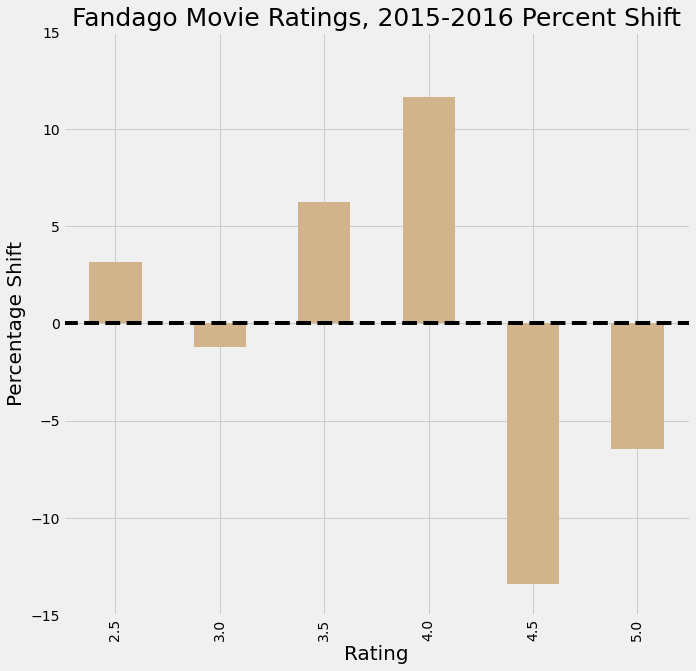

In [20]:
#Creating figure and plot
fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(1,1,1)

#Setting limits and ticks
ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
ax.set_xlim(0,5)
ax.set_ylim(-15,15)

#Title
ax.set_title('Fandago Movie Ratings, 2015-2016 Percent Shift', size = 25)

#Plotting

shift.plot.bar(color = 'tan')

#Adding axes labels

ax.set_xlabel('Rating',fontsize = 20)
ax.set_ylabel('Percentage Shift', fontsize = 20)

#Adding a zero horizontal line

ax.axhline(0, color = 'black'
           ,ls = '--')

On this graph, we see that the percentage of movies rated 4.5 went down by 13%, and the percentage of movies rated 5 went down by 7%. Conversely, there is a symmetrical raise of the percentage of movies rated 3.5 and 4 stars. There are also shifts for the 2.5 and 3.0 ratings, but of lesser importance.

All in all, the left shift is also apparent on this graph: it is mostly due to a shift of ratings from 5 and 4.5 stars to 4.0 and 3.5 stars.

## Comparing 2015 ratings

We also have access to the actual average of user ratings for 2015. We can compare this to the displayed ratings for 2015. If we see a similar shift in the ratings as what we've seen from 2015 to 2016, it is likely that Fandango adjusted its ratings.

The first step is to round the average ratings columns, named 'Fandango_Ratingvalue', to the nearest 0.5. This is how the rating algorithm is supposed to work. Let us define a function that rounds to the nearest 0.5.

In [21]:
def round_half(num):
    return round(2*num,0)/2

before['Fandango_rounded'] = before['Fandango_Ratingvalue'].apply(round_half)

<ipython-input-21-2fd6b04c138b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  before['Fandango_rounded'] = before['Fandango_Ratingvalue'].apply(round_half)


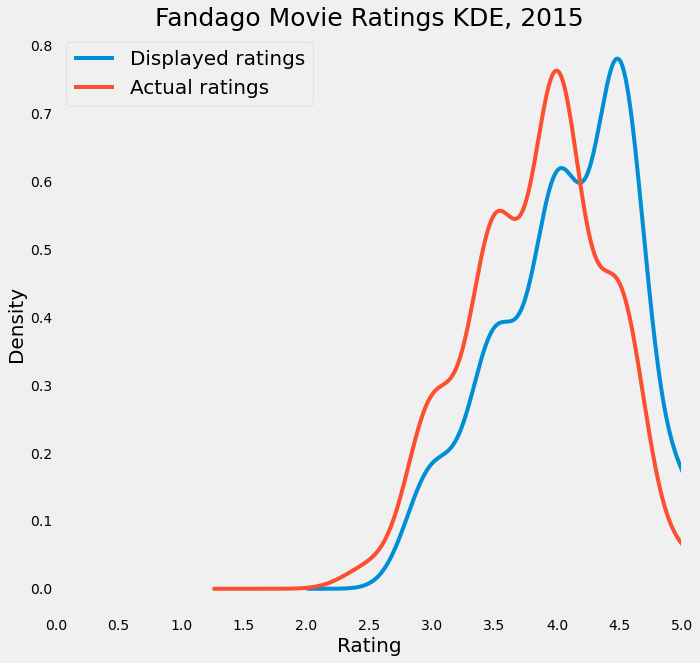

In [22]:
# Use the FTE style
plt.style.use('fivethirtyeight')

#Creating plot and figure

fig = plt.figure(figsize = (10,10))

ax = fig.add_subplot(1,1,1)

#Setting limits and ticks

ax.set_xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
ax.set_xlim(0,5)

ax.set_title('Fandago Movie Ratings KDE, 2015', size = 25)

#Plotting the KDEs

before['Fandango_Stars'].plot.kde(label = 'Displayed ratings')

before['Fandango_rounded'].plot.kde(label = 'Actual ratings')

#Adding legend

ax.legend(loc = 'upper left', fontsize = 20)

#Adding axes labels

ax.set_xlabel('Rating',fontsize = 20)
ax.set_ylabel('Density', fontsize = 20)

# Removing grid
ax.grid(False)


This does look like the previous shift we obtained. We can also compare percent shifts, as was done in the previous section.

In [23]:
true_ratings_dist_15 = before['Fandango_rounded'].value_counts(normalize = True)*100
true_ratings_dist_15.sort_index(inplace = True)

shift_15 = true_ratings_dist_15-ratings_dist_15
shift_15

2.5     1.550388
3.0     4.651163
3.5     7.751938
4.0     7.751938
4.5   -17.054264
5.0    -4.651163
dtype: float64

In [24]:
shifts = pd.concat([shift,shift_15],axis = 1)

shifts.columns = ['2015-2016 Shift', '2015 True Rating Shift']

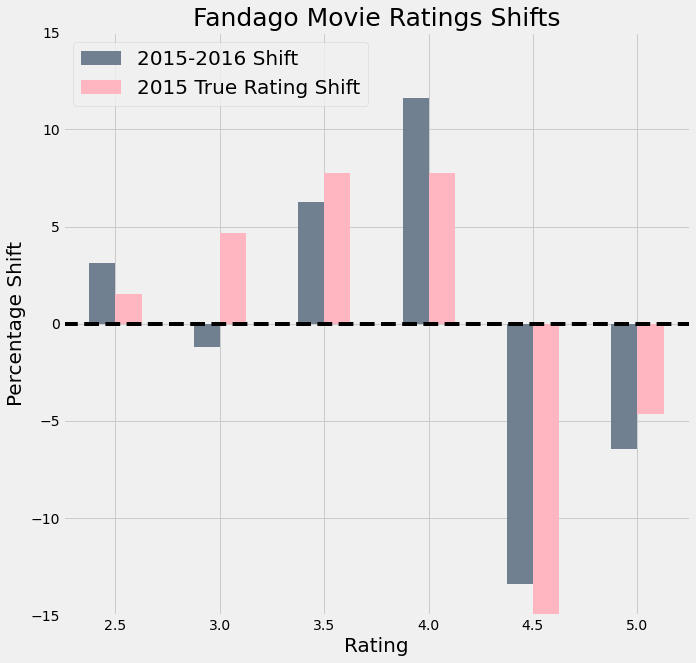

In [25]:
#Plotting
ax = shifts.plot.bar(rot = 0
                     ,color = ['slategrey','lightpink']
                     ,figsize = (10,10))


#Setting limits
ax.set_ylim(-15,15)

#Title
ax.set_title('Fandago Movie Ratings Shifts', size = 25)

#Adding axes labels
ax.set_xlabel('Rating',fontsize = 20)
ax.set_ylabel('Percentage Shift', fontsize = 20)

#Adding a zero horizontal line
ax.axhline(0, color = 'black'
           ,ls = '--')

#Legend
ax.legend(fontsize = 20, loc = 'upper left')

We can see on this bar plot that the two shifts look similar. This gives us more confidence that Fandango changed its algorithm.

## Summary Statistics


To conclude our analysis, we can also compute a few summary statistics for the two tables, such as mean, median and mode.

In [26]:
summary_15 = before['Fandango_Stars'].describe()[['mean','50%']]
summary_15['mode'] = before['Fandango_Stars'].mode()[0]
summary_15.index = ['mean','median','mode']

summary_16 = after['fandango'].describe()[['mean','50%']]
summary_16['mode'] = after['fandango'].mode()[0]
summary_16.index = ['mean','median','mode']

In [27]:
#Combining the two series together

summary = pd.concat({'2015':summary_15,'2016':summary_16}
                    ,axis = 1)

In [28]:
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


We see that both the median and mode dropped in 2016, again pointing to Fandango fixing their algorithm. However, the median did not change. We can plot this data to make our findings more visual.

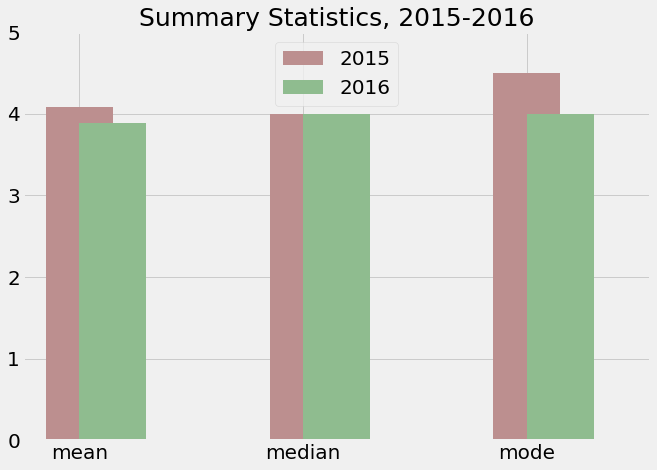

In [29]:
#Creating figure and plot
fig = plt.figure(figsize = (10,7))

ax = fig.add_subplot(1,1,1)

#Setting limits
ax.set_ylim(0,5)

#Title
ax.set_title('Summary Statistics, 2015-2016', size = 25)

#Plotting the stats on the same figure
summary['2015'].plot.bar(color = 'rosybrown'
                         ,align = 'center'
                         ,label = '2015'
                         ,width = 0.3)

summary['2016'].plot.bar(color = 'darkseagreen'
                         ,align = 'edge'
                         ,label = '2016'
                         ,width = 0.3
                         ,rot = 0
                         ,fontsize = 20)

#Adding legend
plt.legend(loc = 'upper center', fontsize = 20)

## 5.Conclusion

All our work points to a left shift in the ratings from 2015 to 2016. This is mainly due to less 5 and 4. stars ratings, and more 4 and 3.5 stars ratings.

This could be explained by Fandango changing their rating algorithm. Indeed, we compared the shift from 2015 to 2016 and the shift from displayed ratings and actual ratings in 2015, and they look similar. However, as our sample size is relatively small, we cannot exclude that this is simply due to random variation in movie ratings between 2015 and 2016.

A next step would be to compare the distribution of ratings on Fandango in 2015-17 versus the distribution on other websites. We would expect the distributions to become closer if Fandango changed their rating algorithm to match the rouded average of customer ratings.